In [1]:
!pip install pennylane pennylane-ionq qiskit[visualization]

In [1]:
import os
import pennylane as qml
from pennylane import numpy as np
from pennylane.templates import RandomLayers
from pennylane_ionq import ops
import matplotlib.pyplot as plt
from qiskit import *
import torch
from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.optim as optim
import torch.nn.functional as F

In [2]:
use_cuda = torch.cuda.is_available()
print(use_cuda)

True


In [3]:
n_epochs = 30   # Number of optimization epochs
n_layers = 1    # Number of random layers
n_train = 128    # Size of the train dataset
n_test = 32     # Size of the test dataset

SAVE_PATH = "quanvolution_pqc/" # Data saving folder
PREPROCESS = True           # If False, skip quantum processing and load data from SAVE_PATH
# np.random.seed(0)           # Seed for NumPy random number generator
# tf.random.set_seed(0)       # Seed for TensorFlow random number generator

In [5]:
BATCH_SIZE = 16
from torch.utils.data import SubsetRandomSampler
train_dataset = datasets.MNIST(root = "./data",
                               train = True,
                               download = True,
                               transform = transforms.ToTensor())

test_dataset = datasets.MNIST(root = "./data",
                              train = False,
                              transform = transforms.ToTensor())

# train_dataset = Subset(train_dataset,range(n_train))
# test_dataset = Subset(test_dataset,range(n_test))

train_sampler = SubsetRandomSampler(range(n_train))
test_sampler = SubsetRandomSampler(range(n_test))

train_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                           batch_size = BATCH_SIZE,
                                           shuffle = False,
                                           sampler = train_sampler)

test_loader = torch.utils.data.DataLoader(dataset = test_dataset,
                                          batch_size = BATCH_SIZE,
                                          shuffle = False,
                                          sampler = test_sampler)


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw




Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 503: Service Unavailable




Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /pytorch/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [21]:
os.environ['IONQ_API_KEY']='1LCa7Dvzz5P35g6B3gwoxzFO04n7gWYH'
dev = qml.device("ionq.qpu", wires=9)

# Random circuit parameters

@qml.qnode(dev, interface='torch')
def pqc(data,params):
    # Encoding of 9 classical input values
    # len(params) = 2 * 9
    # print("data: ",data)
    # print("params: ",params)
    n_qubits = 9
    for j in range(n_qubits):
        qml.RY(np.pi * data[j], wires=j)
    
    # rand_params = np.random.uniform(high=2 * np.pi, size=(n_layers, 9))
    # print("rand", rand_params)
    # PQC
    for i in range(n_qubits):
        qml.RY(params[i], wires=i)
    for i in range(n_qubits-1):
        qml.CNOT(wires=[i,i+1])    
    qml.CNOT(wires=[n_qubits-1,0])
    for i in range(n_qubits):
        qml.RY(params[i+n_qubits], wires=i)
    # Measurement producing 9 classical output values
    return qml.expval(qml.PauliZ(0))

1LCa7Dvzz5P35g6B3gwoxzFO04n7gWYH


In [ ]:
print(pqc([1,0,2,1,2,3,1,2,0],[1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1]))

In [8]:
class QuanvNet(torch.nn.Module):
    def __init__(self,qc=True,opt=True):
        super().__init__()
        self.n_qubits = 9
        self.filters = 1
        self.conv_opt = torch.nn.Conv2d(in_channels=self.filters,out_channels=self.filters,kernel_size=3)
        self.conv1 = torch.nn.Conv2d(in_channels=self.filters,out_channels=8,kernel_size=3)
        self.pre_pool = torch.nn.AvgPool2d(2)
        self.pool = torch.nn.MaxPool2d(2)
        self.conv2 = torch.nn.Conv2d(in_channels=8,out_channels=8,kernel_size=3)
        if qc == True:
          self.fc1 = torch.nn.Linear(32,16)
        else:
          self.fc1 = torch.nn.Linear(32,16)
        self.fc2 = torch.nn.Linear(16,10)
        self.dropout = torch.nn.Dropout(0.4)
        self.q_params = torch.nn.Parameter(2*np.pi*torch.rand(12,12,self.filters,2*self.n_qubits))
        self.q_params.requires_grad = True

    def forward(self, inputs):
        inputs = self.pre_pool(inputs)/255
        qc = False
        if qc == True:
          out = torch.zeros((BATCH_SIZE,self.filters,12,12))
          for bat, image in enumerate(inputs):
              for j in range(1, 13, 1):
                  for k in range(1, 13, 1):
                      for i in range(self.filters):
                          q_results = pqc(
                          [
                              image[0, j - 1, k - 1].item(),
                              image[0, j - 1, k].item(),
                              image[0, j - 1, k + 1].item(),
                              image[0, j, k - 1].item(),
                              image[0, j, k].item(),
                              image[0, j, k + 1].item(),
                              image[0, j + 1, k - 1].item(),
                              image[0, j + 1, k].item(),
                              image[0, j + 1, k + 1].item()
                          ],
                              self.q_params[j-1,k-1,i]
                          )
                          out[bat,i,j - 1, k - 1] = q_results
        else:
          out = torch.zeros((BATCH_SIZE,self.filters,14,14))
          out = inputs
        # print(out.size())
        if opt==True:
          out = self.conv_opt(inputs)
        x = self.pool(F.relu(self.conv1(out)))
        # print(x.size())
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x,1)
        # print(x.size())
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.softmax(self.fc2(x))
        return x



In [9]:
from torchsummary import summary
criterion = torch.nn.CrossEntropyLoss()
model = QuanvNet(qc=False,opt=True)
if use_cuda:
    model.cuda()
opt = optim.Adam(model.parameters(),lr=0.01)
summary(model,(1,28,28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         AvgPool2d-1            [-1, 1, 14, 14]               0
            Conv2d-2            [-1, 8, 12, 12]              80
         MaxPool2d-3              [-1, 8, 6, 6]               0
            Conv2d-4              [-1, 8, 4, 4]             584
         MaxPool2d-5              [-1, 8, 2, 2]               0
            Linear-6                   [-1, 16]             528
           Dropout-7                   [-1, 16]               0
            Linear-8                   [-1, 10]             170
Total params: 1,362
Trainable params: 1,362
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.01
Params size (MB): 0.01
Estimated Total Size (MB): 0.02
----------------------------------------------------------------


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


In [10]:
for p in model.parameters():
    print(p.shape)

torch.Size([12, 12, 1, 18])
torch.Size([1, 1, 3, 3])
torch.Size([1])
torch.Size([8, 1, 3, 3])
torch.Size([8])
torch.Size([8, 8, 3, 3])
torch.Size([8])
torch.Size([16, 32])
torch.Size([16])
torch.Size([10, 16])
torch.Size([10])


In [11]:
losses = []
accs = []
for epoch in range(10000):
  train_loss = 0
  acc = 0
  for (x_train, y_train) in train_loader:
    # print(y_train)
    opt.zero_grad()
    outputs = model(x_train.cuda() if use_cuda else x_train)
    _, preds = torch.max(outputs,1)
    acc += (preds==(y_train.cuda() if use_cuda else y_train)).sum().item()
    loss = criterion(outputs,(y_train.cuda() if use_cuda else y_train))
    loss.backward()
    opt.step()
    train_loss += loss
    del loss
  acc /= n_train
  train_loss /= (n_train/BATCH_SIZE)
  if epoch%10 == 9:
    if epoch%100 == 99:
      print(epoch+1,train_loss)
    losses.append(train_loss.item())
  if epoch%10 == 9:
    accs.append(acc) 
  del acc

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:57: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


100 tensor(2.2774, device='cuda:0', grad_fn=<DivBackward0>)
200 tensor(2.0464, device='cuda:0', grad_fn=<DivBackward0>)
300 tensor(1.8611, device='cuda:0', grad_fn=<DivBackward0>)
400 tensor(1.8236, device='cuda:0', grad_fn=<DivBackward0>)
500 tensor(1.7977, device='cuda:0', grad_fn=<DivBackward0>)
600 tensor(1.7520, device='cuda:0', grad_fn=<DivBackward0>)
700 tensor(1.7200, device='cuda:0', grad_fn=<DivBackward0>)
800 tensor(1.7683, device='cuda:0', grad_fn=<DivBackward0>)
900 tensor(1.7078, device='cuda:0', grad_fn=<DivBackward0>)
1000 tensor(1.7500, device='cuda:0', grad_fn=<DivBackward0>)
1100 tensor(1.7332, device='cuda:0', grad_fn=<DivBackward0>)
1200 tensor(1.7049, device='cuda:0', grad_fn=<DivBackward0>)
1300 tensor(1.7317, device='cuda:0', grad_fn=<DivBackward0>)
1400 tensor(1.7285, device='cuda:0', grad_fn=<DivBackward0>)
1500 tensor(1.7367, device='cuda:0', grad_fn=<DivBackward0>)
1600 tensor(1.7035, device='cuda:0', grad_fn=<DivBackward0>)
1700 tensor(1.7171, device='cuda:

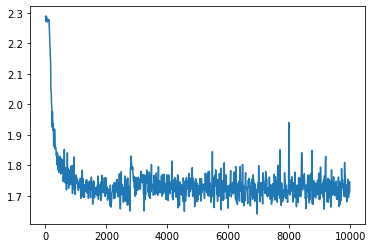

In [12]:
from matplotlib.pyplot import plot
x = np.arange(0,10000,10)
plot(x,losses)

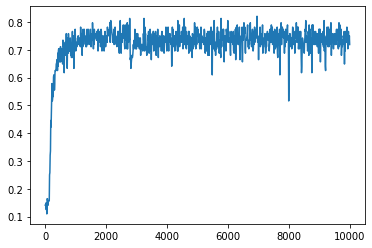

In [13]:
x = np.arange(0,10000,10)
plot(x,accs)